<a href="https://colab.research.google.com/github/Ciela-Institute/Astromatic/blob/main/Astromatic2023/p2_gravitational_lensing_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM 2: Strong gravitational lensing parameter inference

## Problem description
This project’s goal is to infer the mass and lens parameters of a sample of lensing galaxies by their gravitational distortion effect on the image of a background source.

## What’s the main issue?
With upcoming large sky surveys, hundreds of thousands of strong galaxy-galaxy gravitational lenses will be discovered. This is a challenge for characterization of individual lens systems, which can traditionally take multiple days of analysis by experts and traditional inference methods like MCMC.

## Potential solution to this problem?
Convolutional neural networks have shown their capacity for precise and fast (~10,000,000x faster) estimation of strong lensing parameters, which makes the analysis of such a large sample of lenses feasible.

## Milestones
- Craft a neural network for this problem, and its training loop.
- Evaluate the quality of you network, compare it to the litterature on this subject.
- Estimate the network uncertainties on a few parameters of interests. There are multiple approach to this, for example Bayesian Neural Networks, or Simulation-Based Inference methods.
- Compare your posterior with the results of an MCMC, and calibrate your posteriors with a coverage plot. Is you network accurate? Is it precise?


## Useful references
https://arxiv.org/abs/1708.08842 : Fast Automated Analysis of Strong Gravitational Lenses with Convolutional Neural Networks by Hezaveh et al. (2017)
The study of galaxy formation and evolution is an hot topic in current research.

https://arxiv.org/abs/1708.08843 : Uncertainties in Parameters Estimated with Neural Networks: Application to Strong Gravitational Lensing

https://arxiv.org/abs/2012.00042 : Large-Scale Gravitational Lens Modeling with Bayesian Neural Networks for Accurate and Precise Inference of the Hubble Constant by Park et al. (2021)

https://arxiv.org/abs/2112.05278 : Simulation-Based Inference of Strong Gravitational Lensing Parameters by Legin et al (2021)

In [1]:
!pip install caustic pyro-ppl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 603.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 9.7 MB/s eta 0:00:00


In [3]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')
path = "drive/MyDrive/Astromatic2023/Problem2/"

import torch
from torch.func import vmap
import pyro
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
import sys
sys.path.append(path)
from p2_simulator import Simulator, prior

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Simulator

We need an accurate simulator for a gravitational lensing inference. We will be using our own in-house simulator to simulate gravitational lenses
with simple parametric models.

To make things simple, a simulator is a function $f(\mathbf{x})$ of the parameters of interests, $\mathbf{x}$, which has an output that we can compare directly to our observations, in this case images of gravitational lenses.

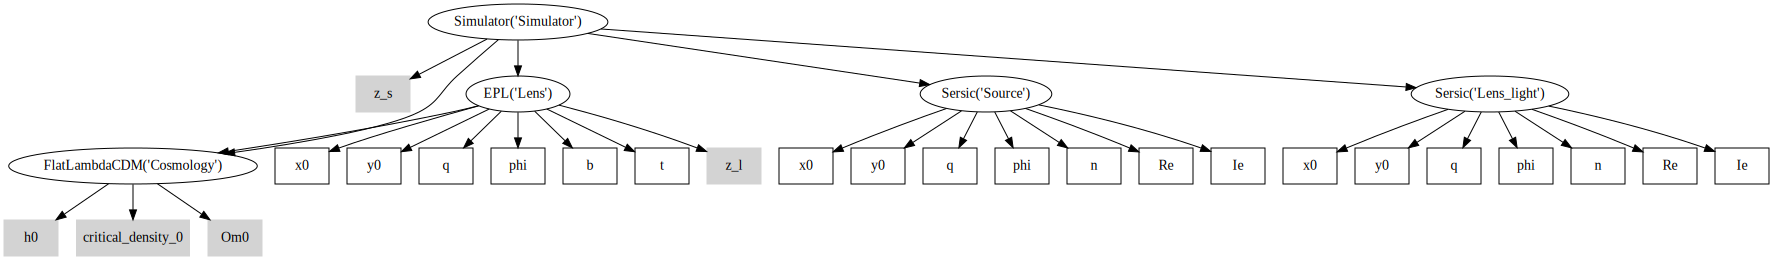

In [4]:
simulator = Simulator()
simulator.get_graph(show_dynamic_params=True, show_static_params=True)

# Graphical model

We also need a graphical model to sample parameters and observation based on our prior distribution $p(\mathbf{x})$. For this, we will be using the package pyro.

The following does not need to be understood in detail, only that the graphical model will produce instances of every random variables we care about. Those are, of course,
simulated observations $\mathbf{y}$ and parameters of interest $\mathbf{x}$.

We impose the following prior on our parameters, where I write $\mathcal{N}(\mu, \sigma)$ for clarity, where $\sigma$ is the standard deviation.

- Positional parameters (in arcseconds units)
$$
    x_0, y_0 \sim \mathcal{N}(0, 0.1)
$$
- Axis ratio (controlling the ellipticity of the profiles)
$$
    q \sim \mathcal{U}(0.4, 1)
$$
- Orientation
$$
    \phi \sim \mathcal{U}(0, \pi)
$$
- Sersic index
$$
    n \sim \mathcal{U}(0.5, 4)
$$
- Sersic effective radius
$$
    R_e \sim \mathcal{U}(0.1, 1)
$$
- Power law slope
$$
    t \sim \mathcal{N}(2, 0.5)
$$
- Einstein radius
$$
    b \sim \mathcal{U}(0.5, 1.5)
$$
- Source effective intensity
$$
    I_e \sim \mathcal{U}(10, 20)
$$
- Lens light effective intensity
$$
    I_e \sim \mathcal{U}(50, 60)
$$

In [5]:
# Modify this dictionary to change the prior
prior_params = {
    "positional": {
        "mean": 0.,
        "sigma": 0.1
    },
    "axis_ratio": {
        "min": 0.4,
        "max": 1
    },
    "orientation": {
        "min": 0.,
        "max": pi
    },
    "sersic_index": {
        "min": 0.5,
        "max": 4
    },
    "sersic_effective_radius": {
        "min": 0.1,
        "max": 1.
    },
    "source_intensity": {
        "min": 10,
        "max": 20
    },
    "lens_light_intensity": {
        "min": 50,
        "max": 60
    },
    "epl_slope": { # t
        "mean": 2.,
        "sigma": 0.5
    },
    "einstein_radius": {
        "min": 0.5,
        "max": 1.5
    }
}

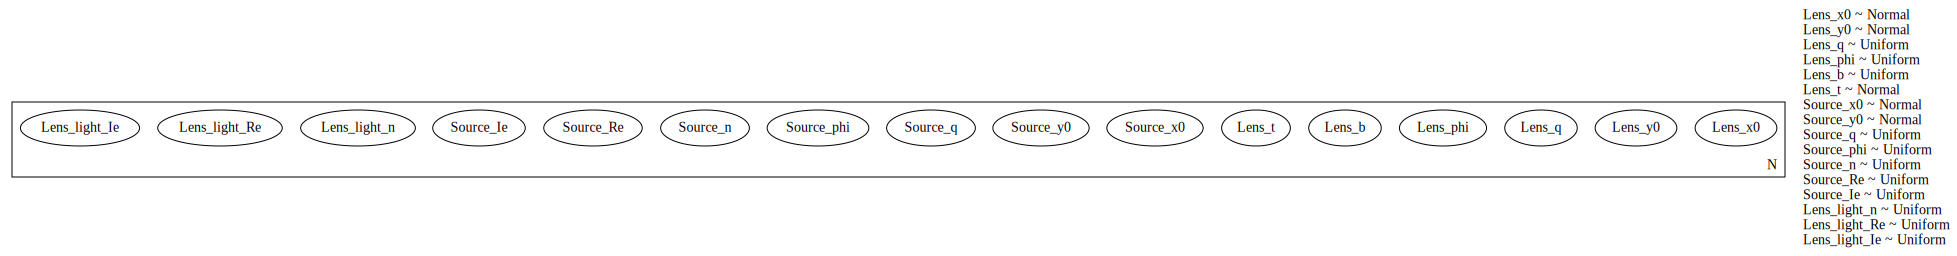

In [6]:
import pyro
pyro.render_model(prior, model_args=(1, simulator, prior_params), render_distributions=True, render_params=False)

# Exploration

## Example 1: Sample the full parameter space

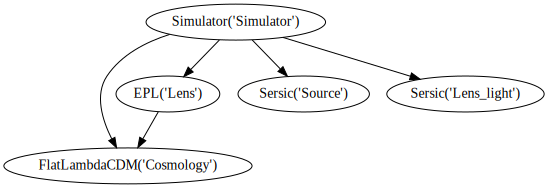

In [7]:
simulator = Simulator()
simulator.get_graph()

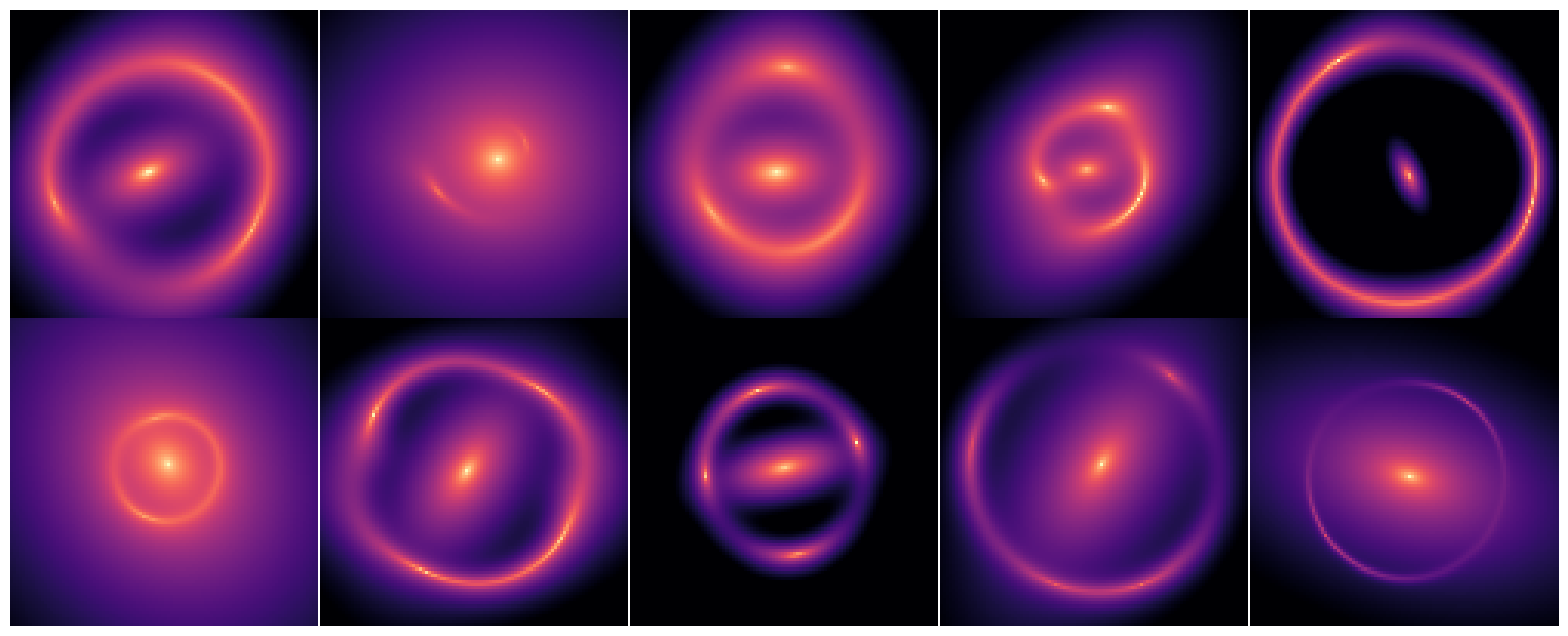

In [8]:
with torch.no_grad():
    N = 10
    params = prior(N, simulator, prior_params)
    y = vmap(simulator)(params)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].imshow(y[k], cmap="magma", norm=plt.cm.colors.LogNorm(vmin=1, clip=True))
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

## Example 2: Simulate without lens light

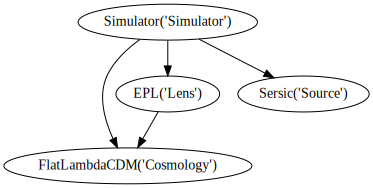

In [9]:
simulator = Simulator(with_lens_light=False)
simulator.get_graph()

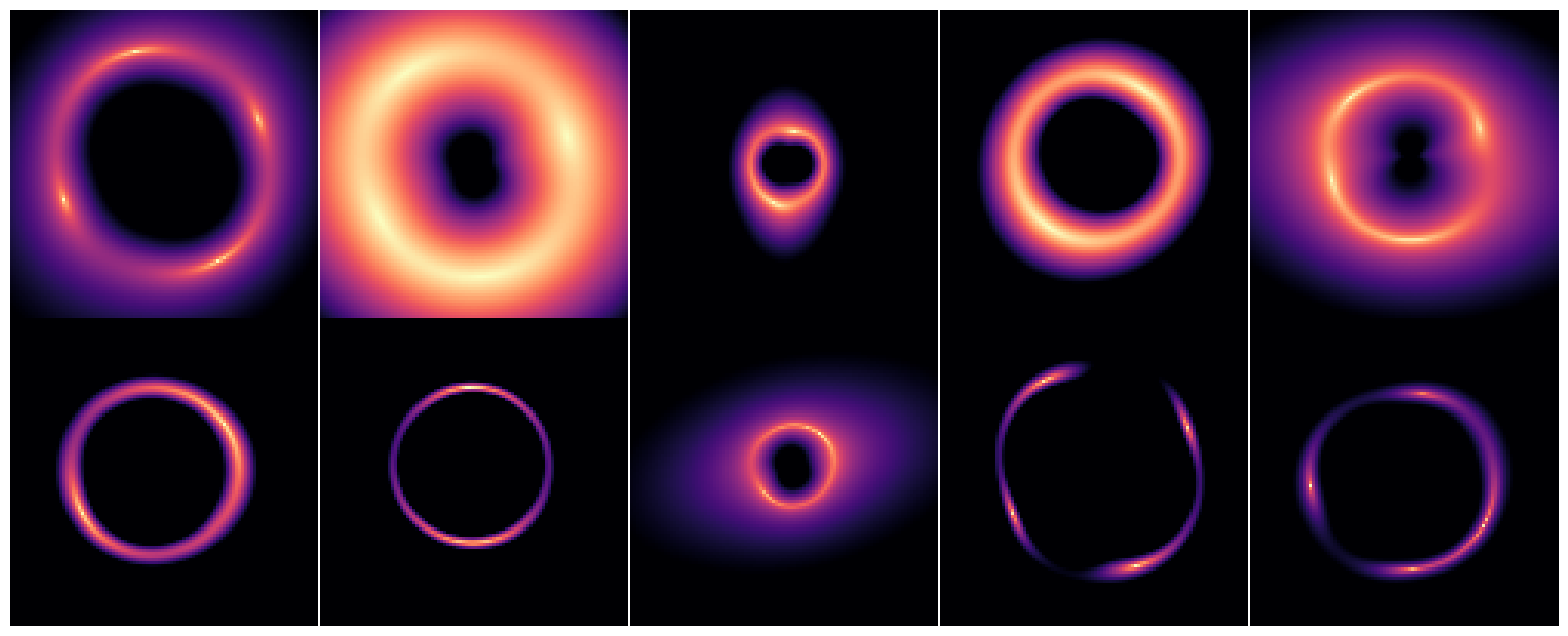

In [10]:
# Our sampling function automatically picks up the fact we we do not have the lens light anymore
with torch.no_grad():
    N = 10
    params = prior(N, simulator, prior_params)
    y = vmap(simulator)(params)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].imshow(y[k], cmap="magma", norm=plt.cm.colors.LogNorm(vmin=1, clip=True))
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

## Example 3: Fix some of the parameters (this is useful to simplfy the problem)

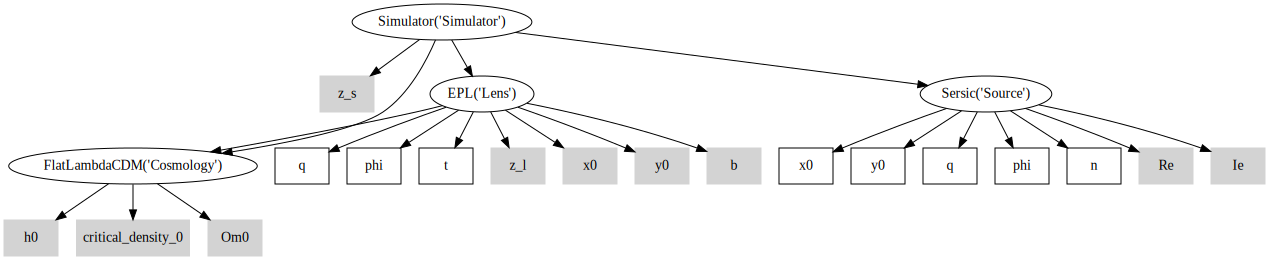

In [11]:
simulator.lens.b = 0.5
simulator.lens.x0 = 0
simulator.lens.y0 = 0
simulator.source.Ie = 10
simulator.source.Re = 0.4
simulator.get_graph(True, True)

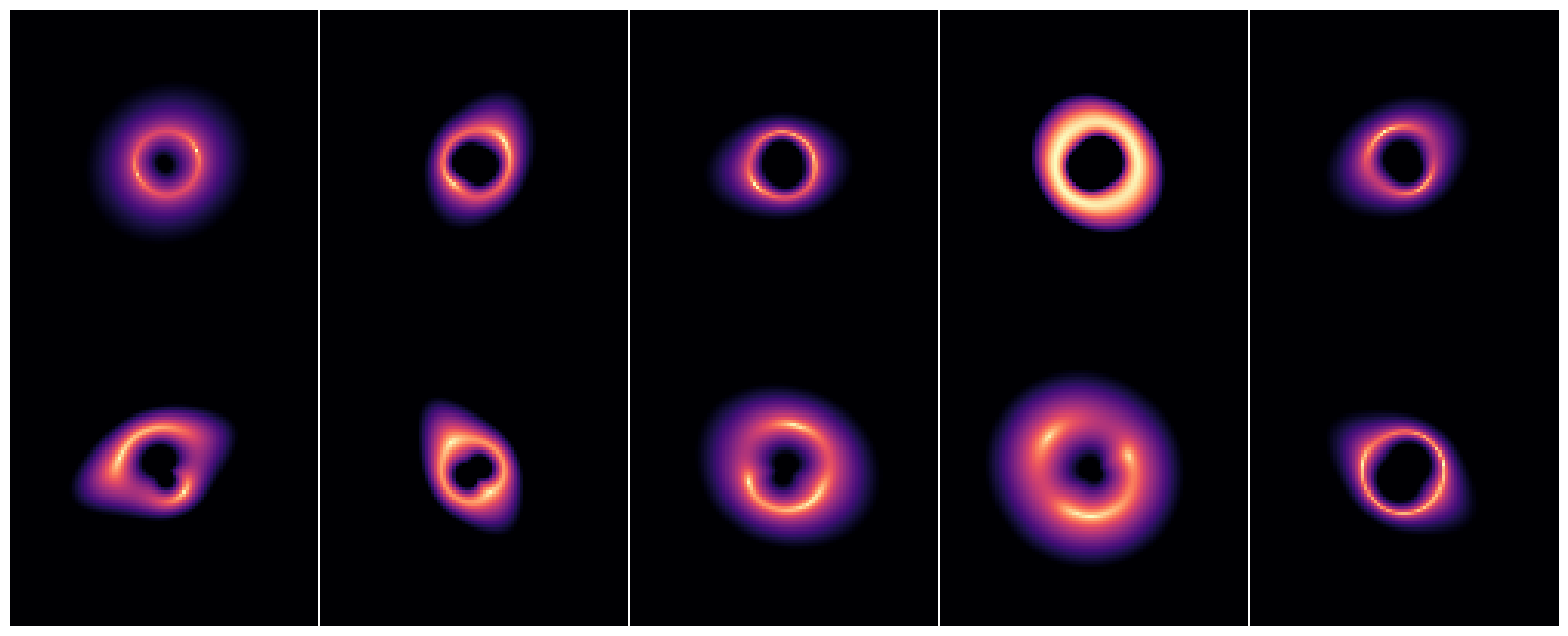

In [12]:
# Our sampling function automatically picks up the fact we we do not have the lens light anymore
with torch.no_grad():
    N = 10
    params = prior(N, simulator, prior_params)
    y = vmap(simulator)(params)

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        k = i * 5 + j
        axs[i, j].imshow(y[k], cmap="magma", norm=plt.cm.colors.LogNorm(vmin=1, clip=True))
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

In [13]:
# You can make the parameter dynamic again by doing the following (or reinitialize the simulator)
simulator.lens.b = None
simulator.lens.x0 = None
simulator.lens.y0 = None
# simulator.get_graph(True, True)

# Dataset

In [14]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, size, batch_size, simulator, prior_params, noise_std):
        self.simulator = simulator
        self.prior_params = prior_params
        self.prior = lambda: prior(self.batch_size, self.simulator, self.prior_params)
        self.size = size
        self.batch_size = batch_size
        self.noise_std = noise_std

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        params = self.prior()
        y = vmap(self.simulator)(params)
        # Simulate noise
        y += torch.randn_like(y) * self.noise_std
        # Reshape params for inference
        params_tensor = []
        for name, p in params.items():
            for p_value in p.values():
                params_tensor.append(p_value)
        params_tensor = torch.stack(params_tensor, dim=1)
        # Note that you can use the simulator with the flattened tensor also
        # y = vmap(simulator)(params_tensor)
        return y, params_tensor # Input is the simulated image, labels are the parameters of interest


In [18]:
# Here is an example how to use the dataset, using a batch size of 64.
size = 1000 # this is arbitrary; sets the length of an epoch
batch_size = 64
noise_std = 1
dataset = Dataset(size, batch_size, simulator, prior_params, noise_std)

epochs = 1
for epoch in range(epochs):
    for y, x in dataset: # y is the input to the network, x are the labels.
        print(y.shape, x.shape)
        # Do your otimization here
        break
# Note that you can use the simulator with the flattened tensor also to check if your reconstructions are good. 
# y = vmap(simulator)(x)

torch.Size([64, 100, 100]) torch.Size([64, 11])
